In [1]:

from scipy.stats import pearsonr
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from Config import get_data_dir


In [2]:
main_dir = './Models'

# Collect the data for each training mode
data = {}
for mode_dir in glob.glob('{}/*'.format(main_dir)):
    mode = mode_dir.split('/')[-1]
    
    if mode != 'initial-transfer' and mode.split('-')[0] != 'partial': #Ignore the models we aren't analyzing
        # Aggregate the data for that mode across the trials
        data_mode = {}
        count = 0
        for trial_dir in glob.glob('{}/trial*'.format(mode_dir)):
            # Include both Accuracy and Search results
            for file in ['results.json', 'search.json']:
                with open('{}/{}'.format(trial_dir, file), 'r') as f:
                    data_tmp = json.load(f)
                for key in data_tmp:
                    if key in data_mode:
                        data_mode[key].append(data_tmp[key])
                    else:
                        data_mode[key] = [data_tmp[key]]

        # We want the average
        for key in data_mode:
            data_tmp = data_mode[key]
            data_mode[key] = '{} ({})'.format(np.round(np.mean(data_tmp), 3), np.round(np.std(data_tmp), 3))

        # Compute aggregated accuracy metrics
        data[mode] = data_mode

# Convert the nested dictionary into a csv
modes = [key for key in data]
modes.sort()
metrics = [key for key in data[modes[0]]]

# Group the results by pair
with open('./FindSCs.json', 'r') as f:
    pairs = json.load(f)

metric_groups = {}
metric_groups['avg'] = [('MAP', 'MAP'), ('MAR', 'MAR')]

for pair in pairs:
    n = len(pair)
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    n_main = len(main)
    tmp = []
    for metric in metrics:
        if metric[:n] == pair:
            name = metric[n+1:]
            tmp.append((name, metric))
    metric_groups[pair] = tmp

# Save the results
for group in metric_groups:

    df = pd.DataFrame()
    df['Mode'] = modes
    for info in metric_groups[group]:
        name = info[0]
        metric = info[1]
        data_tmp = []
        for mode in modes:
            data_tmp.append(data[mode][metric])
        df[name] = data_tmp

    df.to_csv('./Analysis/{}.csv'.format(group), index = False)

In [3]:
# Show the results for each object pair and then the aggregated differences

def remove_var_info(df):
    def remove(x):
        return x.split(' ')[0]
    return df.applymap(remove)

groups = {}
for pair in pairs:
    spurious = pair.split('-')[1]    
    if spurious in groups:
        groups[spurious].append(pair)
    else:
        groups[spurious] = [pair]

cols_acc = ['Mode', 'both', 'just_main', 'just_spurious', 'neither', 'p-gap', 'r-gap', 'b-precision', 'b-recall', 'b-f1']
cols_search = ['Mode', 'both-main-pixel-paint', 'both-spurious-pixel-paint', 'just_main+spurious']
    
def compare(corrected, baseline):
    modes = [corrected, baseline]

    diffs_acc = {}
    for metric in cols_acc[1:]:
        diffs_acc[metric] = []

    diffs_search = {}
    for metric in cols_search[1:]:
        diffs_search[metric] = []

    for key in groups:
        group = groups[key]
        print()
        print()
        print(key)
        print()
        for pair in group:

            print(pair)
                        
            with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
                splits = json.load(f)
                
            for split in splits:
                splits[split] = len(splits[split])
            
            P_S = (splits['both'] + splits['just_spurious']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S_g_M = splits['both'] / (splits['both'] + splits['just_main'])            
            print('P(S|M), P(S):', np.round(P_S_g_M, 3), np.round(P_S, 3))
            
            df = pd.read_csv('./Analysis/{}.csv'.format(pair))

            print('Acc Comparison')
            df_tmp = remove_var_info(df.loc[df['Mode'].isin(modes), cols_acc].copy())
            print(df_tmp.to_string(index = False)) 

            for metric in diffs_acc:
                data_tmp = {}
                names = df_tmp['Mode'].values
                values = df_tmp[metric].values
                for i in range(len(names)):
                    data_tmp[names[i]] = float(values[i])
                if metric in ['p-gap', 'r-gap']:
                    if not np.any(data_tmp == -1):
                        diffs_acc[metric].append(abs(data_tmp[modes[0]]) - abs(data_tmp[modes[1]]))             
                else:
                    if not np.any(data_tmp == -1):
                        diffs_acc[metric].append(data_tmp[modes[0]] - data_tmp[modes[1]])

            print('Search Comparison')
            df_tmp = remove_var_info(df.loc[df['Mode'].isin(modes), cols_search].copy())
            print(df_tmp.to_string(index = False))

            for metric in diffs_search:
                data_tmp = {}
                names = df_tmp['Mode'].values
                values = df_tmp[metric].values
                for i in range(len(names)):
                    data_tmp[names[i]] = float(values[i])

                if not np.any(data_tmp == -1):
                    diffs_search[metric].append(data_tmp[modes[0]] - data_tmp[modes[1]])
            print()
            print()

    print()
    print()
    print()
    print()
    print('Aggregate Differences:')
    
    def get_stats(key, diffs):
        print(key)
        data = diffs[key]
        print('mean (std):', np.round(np.mean(data), 3), np.round(np.std(data), 3))
        print('median:', np.round(np.median(data), 3))
        if key in ['both', 'just_main', 'just_spurious', 'neither', 'b-precision', 'b-recall', 'b-f1',  'both-main-pixel-paint']:
            print('prob > 0:',  np.round(np.mean(np.array(data) > 0), 3))
        elif key in [ 'p-gap', 'r-gap', 'both-spurious-pixel-paint', 'just_main+spurious']:
             print('prob < 0:',  np.round(np.mean(np.array(data) < 0), 3))           
        print()
        print()

    for key in diffs_acc:
        plt.hist(diffs_acc[key], bins = 15)
        plt.title(key)
        plt.show()
        plt.close()
        get_stats(key, diffs_acc)
        
    for key in diffs_search:
        plt.hist(diffs_search[key], bins = 15)
        plt.title(key)
        plt.show()
        plt.close()
        get_stats(key, diffs_search)




person

cell+phone-person
P(S|M), P(S): 0.797 0.542
Acc Comparison
         Mode   both just_main just_spurious neither   p-gap   r-gap b-precision b-recall   b-f1
      auto-v1  0.232     0.392          0.99   0.994  -0.231   -0.16       0.637    0.312  0.413
 initial-tune  0.282     0.324         0.985   0.996  -0.312  -0.042       0.596    0.303  0.393
Search Comparison
         Mode both-main-pixel-paint both-spurious-pixel-paint just_main+spurious
      auto-v1                 0.126                     0.156              0.148
 initial-tune                 0.131                     0.221              0.165


handbag-person
P(S|M), P(S): 0.91 0.542
Acc Comparison
         Mode   both just_main just_spurious neither  p-gap  r-gap b-precision b-recall   b-f1
      auto-v1  0.137     0.042         0.992   0.998  -0.14  0.095       0.569    0.089   0.15
 initial-tune  0.242     0.008         0.975   0.999  0.188  0.234       0.395    0.125  0.187
Search Comparison
         Mode both-

P(S|M), P(S): 0.632 0.1
Acc Comparison
         Mode  both just_main just_spurious neither   p-gap  r-gap b-precision b-recall   b-f1
      auto-v1  0.22     0.155         0.963   0.997  -0.448  0.066       0.275    0.188  0.216
 initial-tune  0.39     0.262         0.904   0.994  -0.482  0.128       0.215    0.326  0.245
Search Comparison
         Mode both-main-pixel-paint both-spurious-pixel-paint just_main+spurious
      auto-v1                 0.072                     0.133              0.119
 initial-tune                 0.093                     0.233              0.155


fork-dining+table
P(S|M), P(S): 0.756 0.1
Acc Comparison
         Mode   both just_main just_spurious neither   p-gap  r-gap b-precision b-recall   b-f1
      auto-v1  0.298     0.261         0.951   0.998  -0.607  0.037       0.291    0.279  0.269
 initial-tune  0.502     0.417         0.886   0.997  -0.674  0.086       0.208    0.459  0.277
Search Comparison
         Mode both-main-pixel-paint both-spurious-

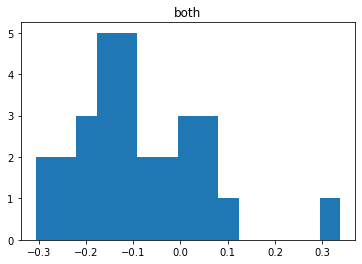

both
mean (std): -0.085 0.133
median: -0.1
prob > 0: 0.276




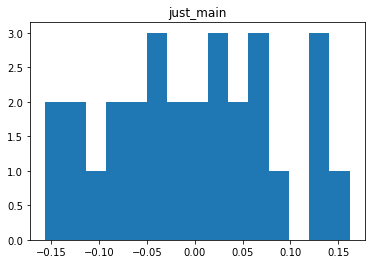

just_main
mean (std): -0.001 0.086
median: -0.003
prob > 0: 0.483




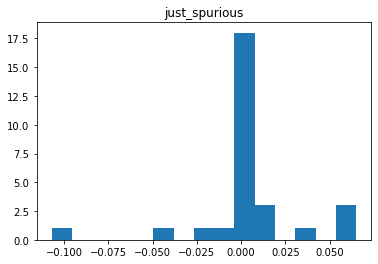

just_spurious
mean (std): 0.004 0.03
median: 0.003
prob > 0: 0.655




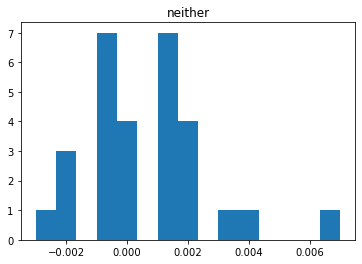

neither
mean (std): 0.0 0.002
median: 0.0
prob > 0: 0.483




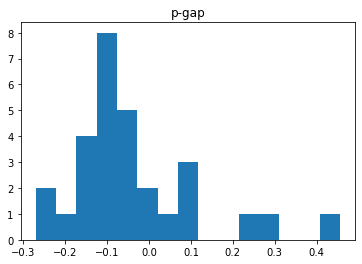

p-gap
mean (std): -0.039 0.15
median: -0.078
prob < 0: 0.724




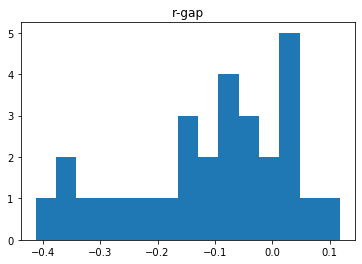

r-gap
mean (std): -0.108 0.138
median: -0.073
prob < 0: 0.759




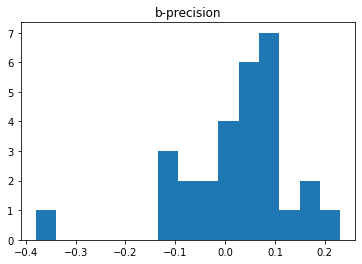

b-precision
mean (std): 0.023 0.112
median: 0.041
prob > 0: 0.69




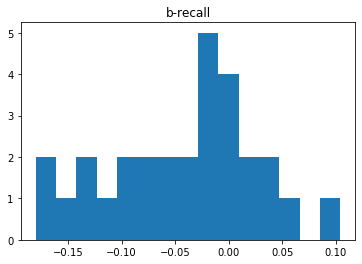

b-recall
mean (std): -0.043 0.07
median: -0.027
prob > 0: 0.276




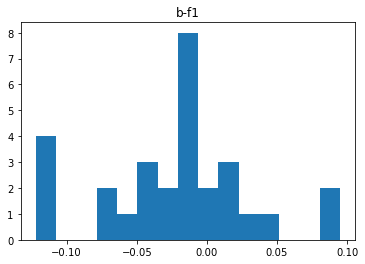

b-f1
mean (std): -0.022 0.052
median: -0.016
prob > 0: 0.276




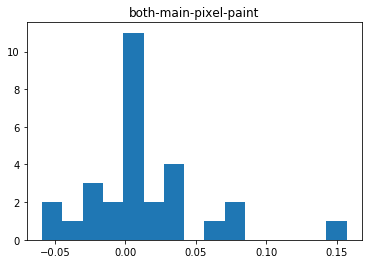

both-main-pixel-paint
mean (std): 0.012 0.042
median: 0.0
prob > 0: 0.448




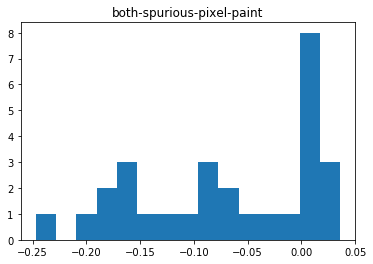

both-spurious-pixel-paint
mean (std): -0.071 0.08
median: -0.065
prob < 0: 0.621




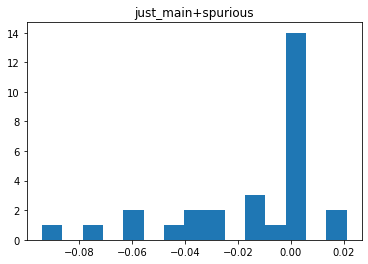

just_main+spurious
mean (std): -0.016 0.027
median: 0.0
prob < 0: 0.448




In [4]:
compare('auto-v1', 'initial-tune')